# Brain Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import nibabel as nib
import h5py
import numpy as np
import surfplot# Fetch the fsLR atlas
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
%matplotlib inline


#### Read roi labels

In [2]:
# Load parameters + data # data/data/glasser_data_glm_then_concat/glm_betas/sub-03/correct_ses5_task-interdmsctgABBA_run-02.csv
subj = 'sub-03'
runs = ['run-01', 'run-02', 'run-03', 'run-04', 'run-05']
sessions = ['ses1', 'ses2', 'ses3', 'ses4', 'ses5', 'ses6', 'ses7', 'ses8', 'ses9', 'ses10', 'ses11', 'ses12', 'ses13', 'ses14', 'ses15', 'ses16']
cwd = os.getcwd()

tasks = ['1backloc', '1backctg', '1backobj', 
         'interdmslocABBA', 'interdmsctgABBA', 'interdmsobjABBA', 
         'interdmslocABAB', 'interdmsctgABAB', 'interdmsobjABAB'] 

# Get the path of the parent directory
parent_dir = '/Users/lucasgomez/Desktop/Neuro/Bashivan/Misc/Hackthon_WM_fMRI' # os.path.abspath(os.path.join(cwd, os.pardir))

basedir = parent_dir
datadir = basedir + '/data/data/glm_betas_encoding_delay_TR_betas/' + subj + '/'

glasser_atlas_str= basedir + '/data/Glasser_LR_Dense64k.dlabel.nii'
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print(glasser_atlas.shape)
num_regions = 360

(64984,)


#### Read betas

In [3]:
task_betas = {}
df_conditions = {} # 'task-dmsloc_run-01'

for task in tasks:
    for sess in sessions:
        for run in runs:
            try:
                h5f = h5py.File(datadir + 'normalized_correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5','r')
                try: 
                    task_betas[task][sess][run] = h5f['betas'][:].copy()
                    df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                except Exception as e:
                    try:
                        task_betas[task][sess] = {}
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        df_conditions[task][sess] = {}
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                    except Exception as e:
                        task_betas[task] = {}
                        task_betas[task][sess] = {}
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        df_conditions[task]= {}
                        df_conditions[task][sess] = {}
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                h5f.close()
            except Exception as e:
                continue


### Isolate first delay betas

In [4]:
filtered_task_betas = task_betas.copy()

for task in task_betas.keys():
    for sess in task_betas[task].keys():
        for run in task_betas[task][sess].keys():
            task_df = df_conditions[task][sess][run]
            filtered_df = task_df[(task_df['prev_stimulus'] == 1000) & (task_df['regressor_type'] == 'encoding')][['Unnamed: 0']] // 2

            betas  = task_betas[task][sess][run]
            betas = betas[:, filtered_df.to_numpy()]

            filtered_task_betas[task][sess][run] = betas

task_betas = filtered_task_betas

#### Region Mapping

In [5]:
map_df_lh = pd.read_excel(basedir + '/data/Glasser_2016_Table.xlsx')
map_df_lh = map_df_lh.iloc[:,0:2]

# Insert row with region 0
map_df_lh.loc[-1] = [0, 'LG']
map_df_lh.index = map_df_lh.index + 1  # shifting index
map_df_lh.sort_index(inplace=True)

# Rename columns
map_df_lh.columns = ['region_id', 'region_name']

map_df_rh = map_df_lh.copy()

# Increase map_df_rh region_id by 180 and index by 180
map_df_rh['region_id'] = map_df_rh['region_id'] + 180
map_df_rh.index = map_df_rh.index + 180

# Concatenate both hemispheres
map_df = pd.concat([map_df_lh, map_df_rh], axis=0)

map_df

,region_id,region_name
0,0,LG
1,1,V1
2,2,MST
3,3,V6
4,4,V2
...,...,...
356,356,STSva
357,357,TE1m
358,358,PI
359,359,a32pr


In [6]:
mapped_atlas = {}

for id, name in zip(map_df['region_id'], map_df['region_name']):
    # indexes of id in glasser_atlas
    if str(name) not in mapped_atlas.keys():
        mapped_atlas[str(name)] = np.where(glasser_atlas == id)[0]
    else:
        mapped_atlas[str(name)] = np.concatenate((mapped_atlas[str(name)], np.where(glasser_atlas == id)[0]))

#### Mask betas

In [7]:
task_betas.keys()

dict_keys(['1backloc', '1backctg', '1backobj', 'interdmslocABBA', 'interdmsctgABBA', 'interdmsobjABBA', 'interdmslocABAB', 'interdmsctgABAB', 'interdmsobjABAB'])

In [8]:
def mask_bad_betas(betas, threshold):

    abs_betas = torch.abs(betas)

    bad_idxs = torch.nonzero(abs_betas > threshold).squeeze()
    good_idxs = torch.nonzero(abs_betas <= threshold).squeeze()

    mean_betas = torch.mean(betas[good_idxs])

    if mean_betas > 0:
        print('mean_betas: ', mean_betas)

    print('bad betas: ', betas[bad_idxs])

    betas[bad_idxs] = mean_betas

    return betas

count = 0

mapped_betas_dict = {}
trial_avg_betas_dict = {}
avg_betas_dict = {}

# Across each region
for name, indexes in mapped_atlas.items():
    mapped_betas_dict[name] = {}
    trial_avg_betas_dict[name] = {}
    avg_betas_dict[name] = {}

    # Across each task
    for task in task_betas.keys():
        mapped_betas_dict[name][task] = {}
        sess_betas = torch.tensor([])

        # Across each session
        for sess in task_betas[task].keys():
            mapped_betas_dict[name][task][sess] = {}
            run_betas = torch.tensor([])

            # Across each run
            for run in task_betas[task][sess].keys():
                # Betas for all trials
                betas = torch.tensor(task_betas[task][sess][run][indexes])

                # Check if betas is all zeros
                if torch.sum(betas) == 0 and name != 'LG':
                    print('Found all zeros for ' + name + ' ' + task + ' ' + sess + ' ' + run)
                    continue

                # Mean beta across trials
                trial_avg_betas = torch.mean(betas, axis=1).unsqueeze(0)
                
                # Add mean beta across trials
                mapped_betas_dict[name][task][sess][run] = trial_avg_betas

                # Add to run_betas
                run_betas = torch.cat((run_betas, trial_avg_betas), axis=0)
            
            # Check if run_betas is not empty
            if run_betas.shape[0] != 0:
                run_betas = torch.mean(run_betas, axis=0).unsqueeze(0)
                sess_betas = torch.cat((sess_betas, run_betas), axis=0)
            else:
                print('no data at: ', name, task, sess, run)
        
        trial_avg_betas_dict[name][task] = sess_betas

        avg_sess_betas = torch.mean(sess_betas, axis=0)  

        avg_betas_dict[name][task] = mask_bad_betas(avg_sess_betas, 10)


bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
mean_betas:  tensor(0.0010, dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
mean_betas:  tensor(0.0008, dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
mean_betas:  tensor(0.7914, dtype=torch.float64)
bad betas:  tensor([[10.0476],
        [ 0.7492]], dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
bad betas:  tensor([], size=(0, 2, 1), dtype=torch.float64)
m

In [9]:
# Task pairs by task type
oneback = ['1backloc', '1backctg', '1backobj']
onebackpairs = [ [oneback[i], oneback[j]] for i in range(len(oneback)) for j in range(i+1, len(oneback))]

interdmsABAB = ['interdmslocABAB', 'interdmsctgABAB', 'interdmsobjABAB']
interdmsABABpairs = [ [interdmsABAB[i], interdmsABAB[j]] for i in range(len(interdmsABAB)) for j in range(i+1, len(interdmsABAB))]

interdmsABBA = ['interdmslocABBA', 'interdmsctgABBA', 'interdmsobjABBA']
interdmsABBApairs = [ [interdmsABBA[i], interdmsABBA[j]] for i in range(len(interdmsABBA)) for j in range(i+1, len(interdmsABBA))]

# Task pairs by stimulus type
loctasks = ['1backloc', 'interdmslocABAB', 'interdmslocABBA']
loctaskpairs = [ [loctasks[i], loctasks[j]] for i in range(len(loctasks)) for j in range(i+1, len(loctasks))]

ctgtasks = ['1backctg', 'interdmsctgABAB', 'interdmsctgABBA']
ctgtaskpairs = [ [ctgtasks[i], ctgtasks[j]] for i in range(len(ctgtasks)) for j in range(i+1, len(ctgtasks))]

objtasks = ['1backobj', 'interdmsobjABAB', 'interdmsobjABBA']
objtaskpairs = [ [objtasks[i], objtasks[j]] for i in range(len(objtasks)) for j in range(i+1, len(objtasks))]

# Baseline pairs for task type
onebloc_taskbaseline = ['1backloc', 'interdmsctgABAB', 'interdmslocABBA']


# Baseline pairs for stimulus type


# All combined
allpairs = [('1back', onebackpairs), ('interdmsABAB', interdmsABABpairs), ('interdmsABBA', interdmsABBApairs), ('loc', loctaskpairs), ('ctg', ctgtaskpairs), ('obj', objtaskpairs)]

beta_difs_dict = {}

for region in mapped_betas_dict.keys():
    beta_difs_dict[region] = {}

    for task_type, task_pairs in allpairs:
        beta_difs_dict[region][task_type] = {}
        for task_pair in task_pairs:
            beta_difs_dict[region][task_type]['-'.join(task_pair)] = (avg_betas_dict[region][task_pair[0]],  avg_betas_dict[region][task_pair[1]], avg_betas_dict[region][task_pair[0]] - avg_betas_dict[region][task_pair[1]])

In [10]:
beta_difs_dict['V1']['1back'].keys()

dict_keys(['1backloc-1backctg', '1backloc-1backobj', '1backctg-1backobj'])

In [11]:
print(avg_betas_dict['V1']['1backloc'])

tensor([[-0.8555],
        [-0.4439],
        [ 0.0816],
        ...,
        [-0.1862],
        [-0.0718],
        [-0.2056]], dtype=torch.float64)


In [12]:
task_base = '1back'
transfer_tasks = ['interdmsABAB', 'interdmsABBA']

stimuli_base = 'loc'
transfer_stimuli = ['ctg', 'obj']

mse_loss = torch.nn.MSELoss()

cross_error_dict = {}
baseline_error_dict = {}

for region in beta_difs_dict.keys():
    cross_error_dict[region] = {}
    baseline_error_dict[region] = {}

    for base_type, transfers  in [(task_base, transfer_tasks), (stimuli_base, transfer_stimuli)]:
        cross_error_dict[region][base_type] = {}

        for t_task in transfers:
            for (_, base), (trans_name, trans) in zip(beta_difs_dict[region][base_type].items(), beta_difs_dict[region][t_task].items()):

                diff = base[2]
                source = trans[0]
                target = trans[1]

                error = mse_loss(source+diff, target)

                if error > 4:
                    print(region)

                cross_error_dict[region][base_type][trans_name] = error

    diff = avg_betas_dict[region]['1backctg'] - avg_betas_dict[region]['1backloc']
    source = avg_betas_dict[region]['1backloc']
    target = avg_betas_dict[region]['interdmsobjABAB']

    error = mse_loss(source+diff, target)

    baseline_error_dict[region]['baseline'] = error
    

V1
V1
V1
V1
V1
V1
V1
MST
MST
MST
MST
MST
MST
V6
V6
V6
V6
V6
V6
V6
V2
V2
V2
V2
V2
V2
V2
V3
V3
V3
V3
V3
V3
V3
V4
V4
V4
V4
V4
V4
V4
V8
V8
V8
V8
V8
V8
V8
4
4
4
4
4
4
4
3b
3b
3b
3b
3b
3b
3b
FEF
FEF
FEF
FEF
FEF
FEF
PEF
PEF
PEF
PEF
PEF
PEF
PEF
55b
55b
55b
55b
55b
55b
55b
V3A
V3A
V3A
V3A
V3A
V3A
RSC
RSC
RSC
RSC
RSC
RSC
RSC
POS2
POS2
POS2
POS2
POS2
POS2
V7
V7
V7
V7
V7
V7
IPS1
IPS1
IPS1
IPS1
IPS1
IPS1
FFC
FFC
FFC
FFC
FFC
FFC
FFC
V3B
V3B
V3B
V3B
V3B
V3B
LO1
LO1
LO1
LO1
LO1
LO1
LO1
LO2
LO2
LO2
LO2
LO2
LO2
LO2
PIT
PIT
PIT
PIT
PIT
PIT
MT
MT
MT
MT
MT
MT
MT
A1
A1
A1
A1
A1
A1
A1
PSL
PSL
PSL
PSL
PSL
PSL
PSL
SFL
SFL
SFL
SFL
SFL
SFL
SFL
PCV
PCV
PCV
PCV
PCV
PCV
PCV
STV
STV
STV
STV
STV
STV
STV
7Pm
7Pm
7Pm
7Pm
7Pm
7Pm
7m
7m
7m
7m
7m
7m
POS1
POS1
POS1
POS1
POS1
POS1
POS1
23d
23d
23d
23d
23d
23d
23d
v23ab
v23ab
v23ab
v23ab
v23ab
v23ab
v23ab
d23ab
d23ab
d23ab
d23ab
d23ab
31pv
31pv
31pv
31pv
31pv
31pv
31pv
5m
5m
5m
5m
5m
5m
5m
5mv
5mv
5mv
5mv
5mv
5mv
5mv
23c
23c
23c
23c
23c
23c
23c
5L
5L
5L
5L
5L
5L
5L
24dd
24dd

In [13]:
avg_cross_error_dict = {}

for region in cross_error_dict.keys():
    avg_cross_error_dict[region] = {}
    for base_type in cross_error_dict[region].keys():
        avg = torch.mean(torch.stack(list(cross_error_dict[region][base_type].values())))
        if avg > 5:
            print(region, base_type, avg)
        avg_cross_error_dict[region][base_type] = avg

V1 1back tensor(5.3457, dtype=torch.float64)
MST 1back tensor(6.5519, dtype=torch.float64)
V6 1back tensor(7.2358, dtype=torch.float64)
V6 loc tensor(5.6224, dtype=torch.float64)
V2 1back tensor(6.0327, dtype=torch.float64)
V4 1back tensor(5.3625, dtype=torch.float64)
V8 loc tensor(5.2841, dtype=torch.float64)
4 1back tensor(7.5773, dtype=torch.float64)
4 loc tensor(5.3010, dtype=torch.float64)
3b 1back tensor(7.2033, dtype=torch.float64)
3b loc tensor(5.5494, dtype=torch.float64)
FEF 1back tensor(5.4388, dtype=torch.float64)
PEF 1back tensor(7.3447, dtype=torch.float64)
55b 1back tensor(6.5349, dtype=torch.float64)
V3A 1back tensor(5.2073, dtype=torch.float64)
RSC 1back tensor(8.7594, dtype=torch.float64)
POS2 1back tensor(6.9091, dtype=torch.float64)
V7 1back tensor(7.8501, dtype=torch.float64)
IPS1 1back tensor(6.6600, dtype=torch.float64)
IPS1 loc tensor(5.0564, dtype=torch.float64)
FFC 1back tensor(5.8105, dtype=torch.float64)
LO1 1back tensor(8.5470, dtype=torch.float64)
LO2 1bac

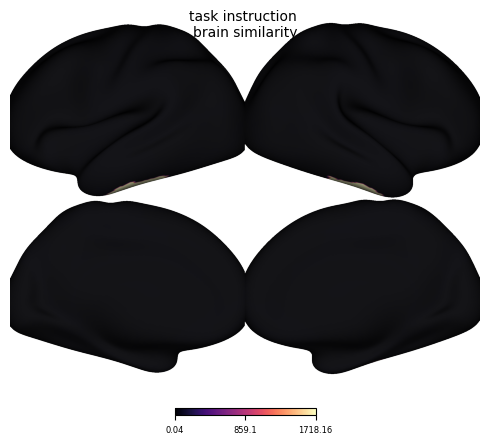

In [14]:
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
surface_dat = np.zeros((len(glasser_atlas),))

count_regs = 0

# Create a surface data array
for name, indexes in mapped_atlas.items():

    count_regs = count_regs + len(indexes)
    
    sim_repeated = np.array([avg_cross_error_dict[name]['1back'].to(torch.float32)]*len(indexes))

    surface_dat[indexes] = np.nan_to_num(sim_repeated)

p = surfplot.Plot(lh,rh,size=(1000,750),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])  
fig = p.build(figsize=(5,5),colorbar=True,cbar_kws={'fontsize':6})
fig.suptitle('task instruction \nbrain similarity',y=0.88,fontsize=10)
fig.tight_layout()
fig.savefig('task_ins_similarity.png',dpi=300)


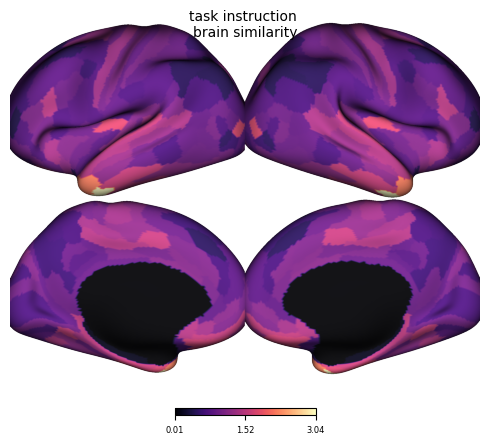

In [15]:
from neuromaps.datasets import fetch_fslr
import surfplot

# Fetch the fsLR atlas
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
surface_dat = np.zeros((len(glasser_atlas),))

count_regs = 0

# Create a surface data array
for name, indexes in mapped_atlas.items():

    count_regs = count_regs + len(indexes)
    sim_repeated = np.array([baseline_error_dict[name]['baseline']]*len(indexes))

    surface_dat[indexes] = np.nan_to_num(sim_repeated)

p = surfplot.Plot(lh,rh,size=(1000,750),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])  
fig = p.build(figsize=(5,5),colorbar=True,cbar_kws={'fontsize':6})
fig.suptitle('task instruction \nbrain similarity',y=0.88,fontsize=10)
fig.tight_layout()
fig.savefig('task_ins_similarity.png',dpi=300)


# Ridge Code

In [16]:
ridge_results = {}
dif_results = {}

for task1 in avg_betas_dict['V1'].keys():
    for task2 in avg_betas_dict['V1'].keys():
        if task2 + '->' + task1 in ridge_results.keys() or task1 == task2:
            continue

        X = np.array(avg_betas_dict['V1'][task1]).reshape(-1, 1)
        Y = np.array(avg_betas_dict['V1'][task2]).reshape(-1, 1)

        # Create the Ridge regression model
        ridge_model = Ridge(alpha=1.0)
        
        # Fit the model to the training data
        ridge_model.fit(X, Y)

        # Predict on the test data
        y_pred = ridge_model.predict(X)
        
        # Evaluate the model
        mse = mean_squared_error(X, y_pred)

        ridge_results[task1 + '->' + task2] = (mse, ridge_model.coef_[0][0], ridge_model.intercept_[0])

        dif_results[task1 + '-' + task2] = avg_betas_dict['V1'][task1] - avg_betas_dict['V1'][task2]


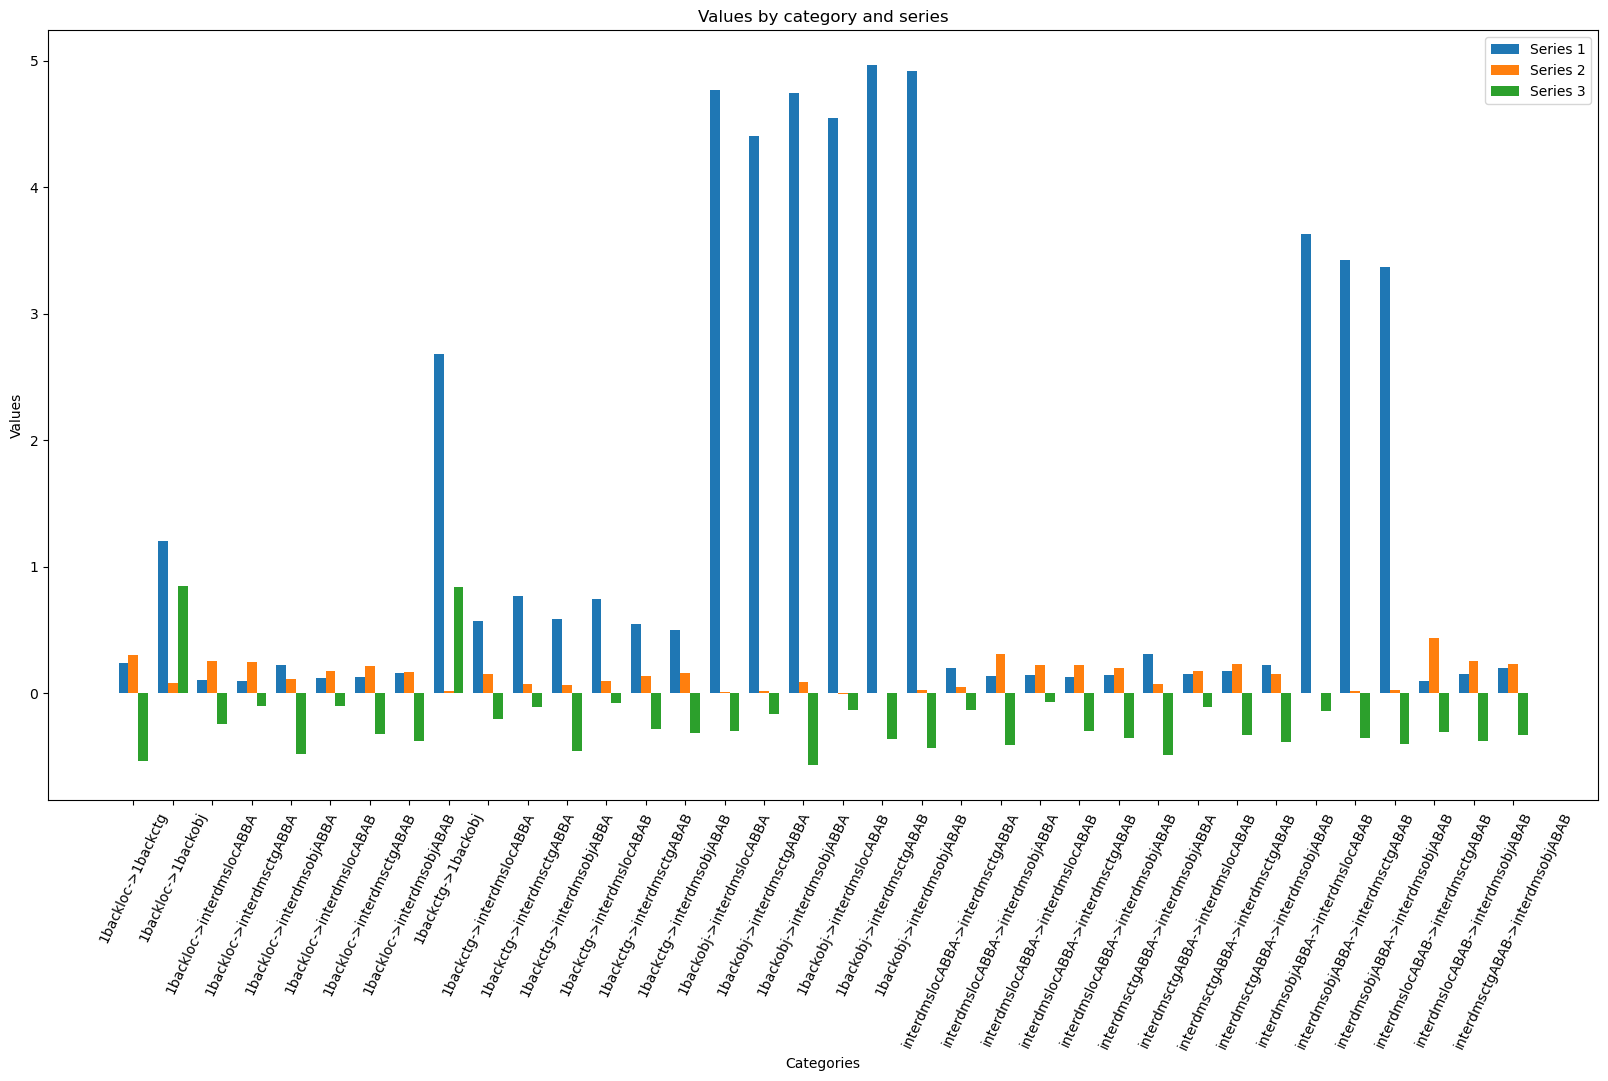

In [17]:
keys = list(ridge_results.keys())
values = np.array(list(ridge_results.values()))

# Create subplots and set the figure size
fig, ax = plt.subplots(figsize=(20, 10))

# Define the positions of the bars on the x-axis
x = np.arange(len(keys))

# Define the width of the bars
width = 0.25

# Plot each series
bars1 = ax.bar(x - width, values[:, 0], width, label='Series 1')
bars2 = ax.bar(x, values[:, 1], width, label='Series 2')
bars3 = ax.bar(x + width, values[:, 2], width, label='Series 3')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Values by category and series')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=65)
ax.legend()

# Display the plot
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

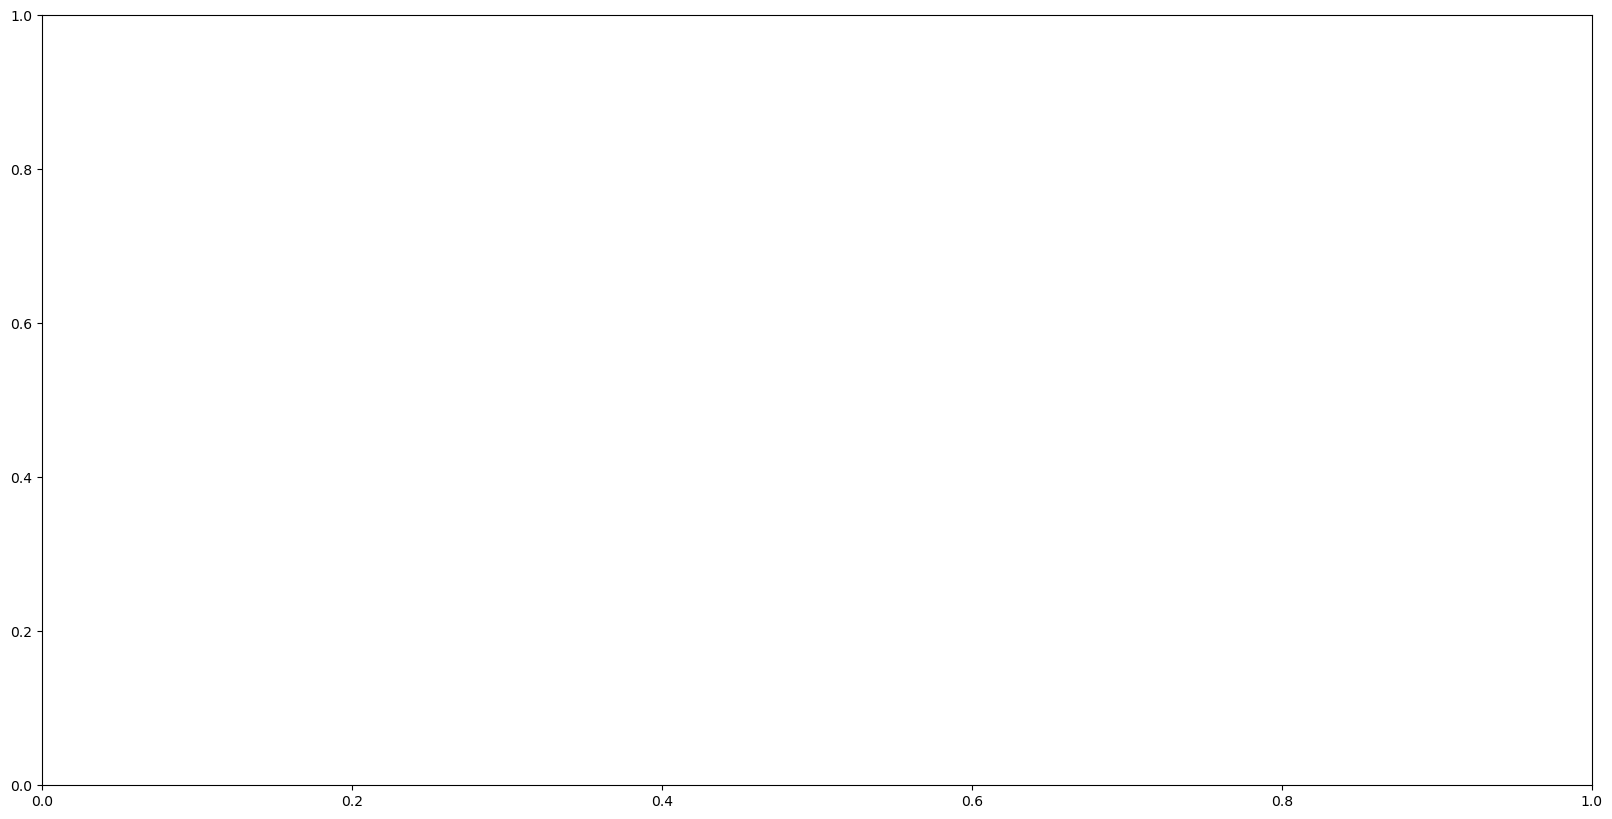

: 

In [18]:
keys = list(dif_results.keys())
values = np.array(list(dif_results.values()))

# Create subplots and set the figure size
fig, ax = plt.subplots(figsize=(20, 10))

# Define the positions of the bars on the x-axis
x = np.arange(len(keys))

# Define the width of the bars
width = 0.25

# import math


# Plot each series
bars1 = ax.bar(x - width, np.abs(values[:, 0]), width, label='Series 1')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Values by category and series')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=65)
ax.legend()

# Display the plot
plt.show()